In [1]:
import numpy as np
import pandas as pd

from collections import OrderedDict

from sklearn.model_selection import train_test_split

import readline 
import rpy2.rinterface
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
pandas2ri.activate()

from CausalTree import *
%run ./datasets/simulate_treatment_data.py


%load_ext rpy2.ipython

In [2]:
%%R 
# read in necessary packages
pack <- c("tidyverse","plyr", "dplyr", "FNN", "modelr", "rpart", "doParallel", "grf")
#invisible(suppressMessages(suppressWarnings(lapply(pack, install.packages, character.only = TRUE))))
invisible(suppressMessages(suppressWarnings(lapply(pack, require, character.only = TRUE))))

# load relevant functions
#source("../Simulation_Study/helper_functions/rf_cate_JASA.R")
#source("../Simulation_Study/helper_functions/simAW.R")

In [3]:
%%R

simAW <- function (n, kC, d, add = FALSE) 
{
    D <- rbinom(n, size = 1, prob = 0.5)
    x <- matrix(runif(n * d), n, d)
    Int <- matrix(rep(0, n * d), n, d)
    for (j in seq_along(D)) {
        Int[j, ] <- D[j] * x[j, ]
    }
    eps0 <- rnorm(n, sd = sqrt(.25))
    eps1 <- rnorm(n, sd = sqrt(.25))
    tau <- function(x1, x2) {
        (1 + (1 + exp(-20 * (x1 - 1/3)))^(-1)) * (1 + (1 + exp(-20 * 
            (x2 - 1/3)))^(-1))
    }
    if (add) {
        betas0 <- matrix(runif(n = d, min = 1, max = 30), nrow = d, 
            ncol = 1)
        betas1 <- matrix(runif(n = d, min = 1, max = 30), nrow = d, 
            ncol = 1)
        y0 <- x %*% betas0 + eps0
        y1 <- x %*% betas1 + eps1
    }
    else {
        y0 <- -0.5 * (tau(x[, 1], x[, 2])) + eps0
        y1 <- 0.5 * (tau(x[, 1], x[, 2])) + eps1
    }
    Xs <- rep(0, d)
    nam <- rep(0, d)
    for (j in 1:d) {
        Xs[j] <- paste("res$X", j, sep = "")
        nam[j] <- paste("I", j, sep = "")
    }
    res <- data.frame(x)
    res <- as_tibble(res)
    Int_XD <- data.frame(Int)
    colnames(Int_XD) <- nam
    Int_XD <- as_tibble(Int_XD)
    res <- bind_cols(res, Int_XD)
    res <- add_column(res, D = D, Y0 = y0, Y1 = y1, Y_obs = rep(0, 
        n))
    res$Y_obs[res$D == 1] <- res$Y1[res$D == 1]
    res$Y_obs[res$D == 0] <- res$Y0[res$D == 0]
    allX <- grep("^[X]", names(res), value = TRUE)
    Tg <- res[res$D == 1, allX]
    Cg <- res[res$D == 0, allX]
    Tgy <- res$Y_obs[res$D == 1]
    Cgy <- res$Y_obs[res$D == 0]
    nnTg2 <- get.knnx(data = Tg, query = res[, allX], kC)
    treat <- apply(matrix(data = Tgy[nnTg2$nn.index], dim(nnTg2$nn.index)), 
        1, mean)
    nnCg2 <- get.knnx(data = Cg, query = res[, allX], kC)
    cont <- apply(matrix(data = Cgy[nnCg2$nn.index], dim(nnCg2$nn.index)), 
        1, mean)
    vhat <- (var(res$Y_obs[nnTg2$nn.index]) + var(res$Y_obs[nnCg2$nn.index]))/(kC * 
        (kC - 1))
    res <- add_column(res, tauhatknn = treat - cont)
    res <- add_column(res, vartauhatknn = vhat)
    allX <- grep("^[X]", names(res), value = TRUE)
    allDX <- grep("^[I]", names(res), value = TRUE, ignore.case = FALSE)
    all <- c(allX, allDX)
    fmla <- as.formula(paste("Y_obs ~ D + ", paste(all, collapse = "+")))
    reslm <- lm(fmla, data = res)
    coef <- matrix(reslm$coefficients[c(allDX, "D")], nrow = d + 
        1, ncol = 1)
    const <- matrix(rep(1, n), nrow = n, ncol = 1)
    X <- as.matrix(cbind(res[, c(allX)], const))
    C_ols <- as.vector(t(coef) %*% t(X))
    res <- add_column(res, Cate_ols = C_ols)
    if (add) {
        res <- add_column(res, CATE = x %*% (betas1 - betas0))
    }
    else {
        res <- add_column(res, CATE = tau(res$X1, res$X2))
    }
    return(res)
}

In [4]:
%%R
# set parameter values
n  <- 200 # number of observations
K  <- 2 # number of covariates 
kC <- 20 # number of nearest neighbors (for knn) 

# simulate data 
r_df <- simAW(n, kC, K)

train_ind  <- sample(seq_len(n), size = floor(.7 * n))
r_df_train <- r_df[train_ind, ]
r_df_test  <- r_df[-train_ind, ]

# compute cate using grf
allX <- grep("^[X]", names(r_df_train), value = TRUE)
cf <- grf::causal_forest(X = as.matrix(r_df_train[, allX]), 
                         Y = as.matrix(r_df_train$Y_obs),
                         W = as.matrix(r_df_train$D),
                         num.trees = 100,
                         num.threads = 1,
                         honesty = FALSE)
        
cf_pred <- predict(cf, as.matrix(r_df_test[, allX]))
cf_mse <- sum((r_df_test$CATE- cf_pred)^2) / nrow(r_df_test)

In [ ]:
ro.con

In [5]:
r_df_train = ro.r('r_df_train')
r_df_test = ro.r('r_df_test')
r_mse_grf = ro.r('cf_mse')
K = ro.r('K')
with localconverter(ro.default_converter + pandas2ri.converter):
    df_train = ro.conversion.rpy2py(r_df_train)
    df_test = ro.conversion.rpy2py(r_df_test)
    mse_grf = ro.conversion.rpy2py(r_mse_grf)
    K = int(ro.conversion.rpy2py(K))

df_train.head()

,X1,X2,I1,I2,D,Y0,Y1,Y_obs,tauhatknn,vartauhatknn,Cate_ols,CATE
1,0.502407,0.745592,0.502407,0.745592,1,-2.282997,2.133539,2.133539,3.772344,0.012884,3.501534,3.933725
2,0.025000,0.678987,0.025000,0.678987,1,-0.709554,0.952836,0.952836,2.218293,0.012884,2.275795,2.003192
3,0.000164,0.041822,0.000000,0.000000,0,-0.876292,-0.604256,-0.876292,1.648323,0.012884,0.664594,1.004208
4,0.344124,0.231609,0.344124,0.231609,1,-0.698048,0.681699,0.681699,1.952608,0.012884,1.893972,1.733404
5,0.916507,0.953882,0.000000,0.000000,0,-1.754475,1.382016,-1.754475,4.306808,0.012884,4.932282,3.999975


In [38]:
X_test = (df_test.iloc[:, 0:K]).copy()

y_train = df_train['Y_obs'].copy()
X_train = df_train.iloc[:, 0:K].copy()
D_train = df_train['D'].copy()

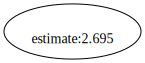

In [39]:
%run ./CausalTree.py

ctree_sparse, ctree_opt = CausalTree.apply_kFold_CV(X_train, y_train, D_train, k = 10)

ctree_opt.plot()

In [40]:
tree_max = CausalTree()
tree_max.fit(X_train, y_train, D_train)
for i in [2]:
    tree_list = CausalTree.get_level_in_list(tree_max, i)
    for tree in tree_list:
        tree.left_child = None
        tree.right_child = None

In [41]:
tau_hat_causal_tree = tree_max.predict(X_test)
tau_hat_knn = df_test['tauhatknn'].values
tau_hat_ols = df_test['Cate_ols'].values
tau_real = df_test['CATE'].values

tau_hat_dict = OrderedDict()
tau_hat_dict["knn"] = tau_hat_knn
tau_hat_dict["ols"] = tau_hat_ols,
tau_hat_dict["ctree"] = tau_hat_causal_tree

mse_dict = OrderedDict()
mse_dict['grf'] = float(mse_grf)

for key, value in tau_hat_dict.items():
    mse_dict[key] = ((tau_real - value) ** 2).mean()

In [42]:
mse_dict

OrderedDict([('grf', 0.15554749219445071),
             ('knn', 0.16384247763284923),
             ('ols', 0.2899705408551977),
             ('ctree', 0.17473480041086203)])

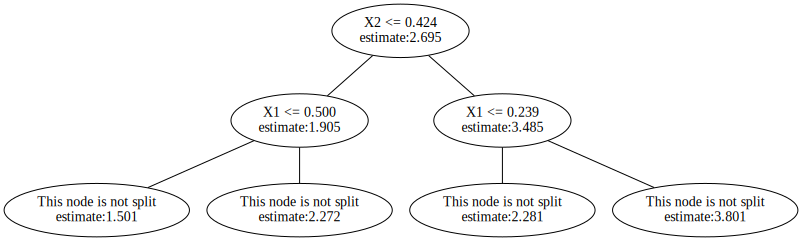

In [43]:
tree_max.plot()

In [44]:
X, y, D = simulate_treatment_data(noise=True)

In [45]:
sparse, opt = CausalTree.apply_kFold_CV(X, y, D)

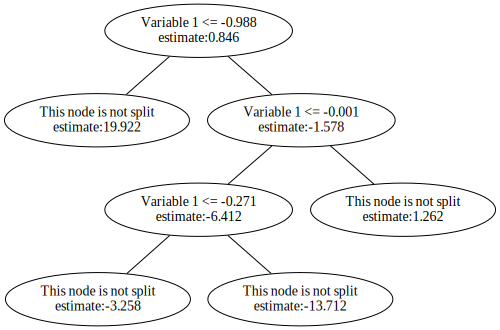

In [46]:
sparse.plot()

In [47]:
treatment_status_learn = D_train
k = 5
thresh=0

In [48]:
        tree_max = CausalTree()
        tree_max.fit(X_train, y_train, treatment_status_learn)
        X_learn = coerce_to_ndarray(X_train)
        y_learn = coerce_to_ndarray(y_train)

        kf = KFold(k)
        tree_max = tree_max  # complete maximal tree
        tree_max_sequences = CausalTree.get_pruned_tree_and_alpha_sequence(
            tree_max, thresh
        )
        tree_k_max_list = []  # list of maximal trees in each cross validation sample
        #tree_k_subtree_list = []
        test_X = []
        test_y = []
        test_treatment_status = []

In [49]:
        for train_index, test_index in kf.split(X_learn, y_learn):
            tmp_tree = CausalTree()
            if treatment_status_learn is None:
                train_treatment_status = None
            else:
                train_treatment_status = treatment_status_learn[train_index]
            tmp_tree.fit(
                X_learn[train_index], y_learn[train_index], train_treatment_status
            )
            tree_k_max_list.append(tmp_tree)
            test_X.append(X_learn[test_index])
            test_y.append(y_learn[test_index])
            test_treatment_status.append(treatment_status_learn[test_index])

In [50]:
        alphas = tree_max_sequences["alphas"]
        potential_subtrees = tree_max_sequences["subtrees"]

        alpha_cv_errors = []
        for alpha in alphas:
            err_alpha = 0
            for k, cv_tree in enumerate(tree_k_max_list):
                cv_alpha_subtree = CausalTree.get_subtree_given_alpha(
                    cv_tree, alpha, thresh
                )
                test_y_transformed = CausalTree.transform_outcome(
                    test_y[k], test_treatment_status[k]
                )
                err_alpha += CausalTree.validate(
                    cv_alpha_subtree, test_X[k], test_y_transformed
                )
            alpha_cv_errors.append(err_alpha)

In [51]:
for i in range(len(potential_subtrees)):
    print((CausalTree.validate(potential_subtrees[i], X_train, CausalTree.transform_outcome(y_train, D_train)), 
           CausalTree.validate(potential_subtrees[i], X_test, tau_real)))

(0.7208119667378113, 0.12041702592616067)
(0.721922907293987, 0.12167231646521695)
(0.7307347184967942, 0.1085213846091294)
(0.7550784522740372, 0.12071054327489647)
(0.8042588577200392, 0.13264845729353988)
(0.8385547649245289, 0.17473480041086203)
(0.9088774927122475, 0.20666725697265978)
(1.1058463232294802, 0.6274064705685111)
(1.7689595468868848, 1.0358055374058734)


In [53]:
        sparsity_bias = 0.5
        alpha_cv_errors = np.array(alpha_cv_errors)
        optimal_index = int(np.where(alpha_cv_errors == alpha_cv_errors.min())[0][-1])
        sparsity_adjustment = sparsity_bias * np.std(alpha_cv_errors)
        optimal_sparse_index = int(
            np.where(
                alpha_cv_errors <= alpha_cv_errors[optimal_index] + sparsity_adjustment
            )[0][-1]
        )
        optimal_subtree = potential_subtrees[optimal_index]
        
        optimal_subtree._cv_error = alpha_cv_errors[optimal_index]
        optimal_sparse_subtree = potential_subtrees[optimal_sparse_index]
    
        optimal_sparse_subtree._cv_error = alpha_cv_errors[optimal_sparse_index]